## AI Fairness 360

## Environment 

In [1]:
# Env creation script
# Cut from conda create command: conda-forge::aif360
env_script = """conda create --name fair-env python=3.12 jupyter notebook pandas scikit-learn matplotlib seaborn  conda-forge::lightgbm -y
conda activate fair-env
python -m ipykernel install --user --name=fair-env
pip install -r requirements.txt

# pip install igraph
# pip install torch torchvision torchaudio
# pip install tensorflow-macos tensorflow-metal
# pip install 'aif360[Reductions]'
# pip install 'aif360[OptimalTransport]'
# pip install 'aif360[inFairness]'
# pip install 'aif360[FairAdapt]'
# pip install 'aif360[AdversarialDebiasing]'
# pip install pycairo

# echo "Environment created and activated"

"""
#    'lightgbm>=3.3.3'
with open('environment-creation-aifair360.sh', 'w') as f:
    f.write(env_script)
    
## removal script
remove_script = """conda deactivate
conda remove --name fair-env --all -y 
echo "Environment removed"
"""
with open('environment-deletion-aifair360.sh', 'w') as f:
    f.write(remove_script)

In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import igraph

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.preprocessing import FairAdapt

/opt/homebrew/Caskroom/miniforge/base/envs/fair-env/lib/python3.12/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [3]:
X, y, sample_weight = fetch_adult()
n_samp = 5000

X = X.drop(['education', 'capital-gain', 'capital-loss', 'relationship'], axis=1)
X = X[0:n_samp]
y = y[0:n_samp]

X.head()

age  workclass  education-num      marital-status  \
race      sex                                                       
Non-white Male   25    Private              7       Never-married   
White     Male   38    Private              9  Married-civ-spouse   
          Male   28  Local-gov             12  Married-civ-spouse   
Non-white Male   44    Private             10  Married-civ-spouse   
White     Male   34    Private              6       Never-married   

                       occupation   race   sex  hours-per-week native-country  
race      sex                                                                  
Non-white Male  Machine-op-inspct  Black  Male              40  United-States  
White     Male    Farming-fishing  White  Male              50  United-States  
          Male    Protective-serv  White  Male              40  United-States  
Non-white Male  Machine-op-inspct  Black  Male              40  United-States  
White     Male      Other-service  White  Male              30  United-States

In [4]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.8, random_state=1234567)

In [5]:
clf = LGBMClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

[LightGBM] [Info] Number of positive: 997, number of negative: 3003
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.249250 -> initscore=-1.102616
[LightGBM] [Info] Start training from score -1.102616


0.83

In [6]:
# parity gap
par_gap = statistical_parity_difference(y_test, y_pred, prot_attr="sex", 
                                         priv_group="Male", pos_label=">50K")
print(f"Parity gap equals {par_gap:.2%}")

Parity gap equals -20.14%


In [7]:
# construct an adjacency matrix
train_df = pd.concat([X_train, y_train], axis=1)
adj_mat = pd.DataFrame(
    np.zeros((len(train_df.columns), len(train_df.columns)), dtype=int),
    index=train_df.columns.values,
    columns=train_df.columns.values
)

# Construct the adjacency matrix of the causal graph
adj_mat.loc[["sex", "age", "native-country", "race"],
            ["marital-status", "education-num","workclass", "hours-per-week", "occupation", "annual-income"]] = 1
adj_mat.loc["marital-status",
            ["education-num", "workclass", "hours-per-week", "occupation", "annual-income"]] = 1
adj_mat.loc["education-num",
            ["workclass", "hours-per-week", "occupation", "annual-income"]] = 1
adj_mat.loc[["workclass", "hours-per-week", "occupation"],
            "annual-income"] = 1

In [8]:
# !pip install pycairo

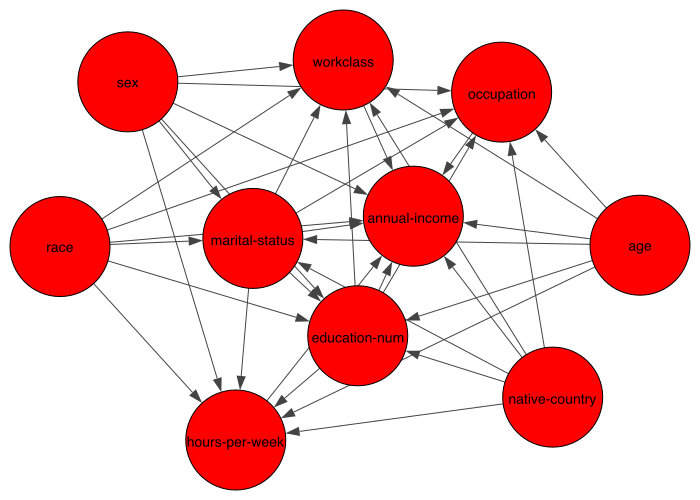

In [9]:
G = igraph.Graph.Adjacency(matrix=adj_mat.values.tolist())
G.vs['label'] = adj_mat.columns
igraph.plot(G, bbox=(0, 0, 700, 500), vertex_size=100, margin=60)

In [12]:
FA = FairAdapt(prot_attr="sex", adj_mat=adj_mat)
# Xf_train, yf_train, Xf_test = FA.fit_transform(X_train, y_train, X_test)

R[write to console]: Installing packages into ‘/opt/homebrew/lib/R/4.4/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘colorspace’, ‘munsell’, ‘Rcpp’, ‘RcppEigen’, ‘ggplot2’, ‘cowplot’, ‘scales’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/colorspace_2.1-0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2116339 bytes (2.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]

In [ ]:
Xf_train, yf_train, Xf_test = FA.fit_transform(X_train, y_train, X_test)